In [1]:
# to run notebook inside of package
import sys
sys.path.append('/Users/mollyliebeskind/Documents/auto_forecast/auto_forecast')

# standard data manipulation imports
import pandas as pd

# import internal package functions
from src.plotting import *
from src.data_processing import *
from src.modeling import SalesForecasting

2023-08-22 15:29:21.762342: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Run the package

In [2]:
value_col = 'sales'
diffed_value_col = f"{value_col}_differenced"
date_col = 'date'
mean_freq = 'Y'
forecast_horizon = 12
model_list = ['LinearRegression', 'RandomForest', 'XGBoost', 'LSTM', 'ARIMA'] 

daily_data = pd.read_csv('train.csv')

monthly_data = aggregate_by_time(
    daily_data, 
    date_col, 
    resample_freq='M', 
    aggregate='sum'
    )

monthly_data = difference_data(
    data=monthly_data, 
    date_col=date_col,
    value_col=value_col, 
    diff_value_col_name=diffed_value_col
    )

supervised_data = create_lag_data(
    data=monthly_data, 
    date_col=date_col, 
    value_col=diffed_value_col, 
    lags=13)

# train, test = create_train_test(supervised_data, test_size)

x_cols = list(supervised_data.drop(['store', 'item', date_col, value_col, diffed_value_col], axis=1).columns)
supervised_data = supervised_data[[date_col] + x_cols + [diffed_value_col]]
train, test = create_train_test(supervised_data, forecast_horizon)

scaler = DataScaler()
print('Train data shape: ', train.shape)
train_scaled = scaler.fit_transform(train).set_index(date_col)
test_scaled = scaler.transform(test).set_index(date_col)
print('Train data shape: ', train_scaled.shape)

model = SalesForecasting(model_list=model_list)
model.fit(train_scaled[x_cols], train_scaled[[diffed_value_col]])
output = model.predict(test_scaled[x_cols], y_values=test_scaled[[diffed_value_col]], scaler=scaler)

Train data shape:  (35, 14)
Train data shape:  (35, 13)


/Users/mollyliebeskind/Documents/auto_forecast/auto_forecast/src/modeling.py:87: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return model.fit(self.X_train, self.y_train)


Epoch 1/200
35/35 [==============================] - 2s 1ms/step - loss: 0.2349 
Epoch 2/200
35/35 [==============================] - 0s 1ms/step - loss: 0.2005
Epoch 3/200
35/35 [==============================] - 0s 2ms/step - loss: 0.1773
Epoch 4/200
35/35 [==============================] - 0s 1ms/step - loss: 0.1606
Epoch 5/200
35/35 [==============================] - 0s 1ms/step - loss: 0.1477
Epoch 6/200
35/35 [==============================] - 0s 1ms/step - loss: 0.1369
Epoch 7/200
35/35 [==============================] - 0s 1ms/step - loss: 0.1273
Epoch 8/200
35/35 [==============================] - 0s 1ms/step - loss: 0.1184
Epoch 9/200
35/35 [==============================] - 0s 1ms/step - loss: 0.1101
Epoch 10/200
35/35 [==============================] - 0s 1ms/step - loss: 0.1022
Epoch 11/200
35/35 [==============================] - 0s 1ms/step - loss: 0.0945
Epoch 12/200
35/35 [==============================] - 0s 1ms/step - loss: 0.0872
Epoch 13/200
35/35 [================

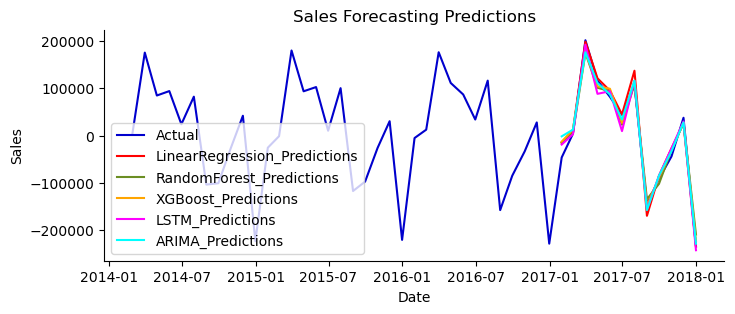

In [3]:
results_plot = model.plot_results()

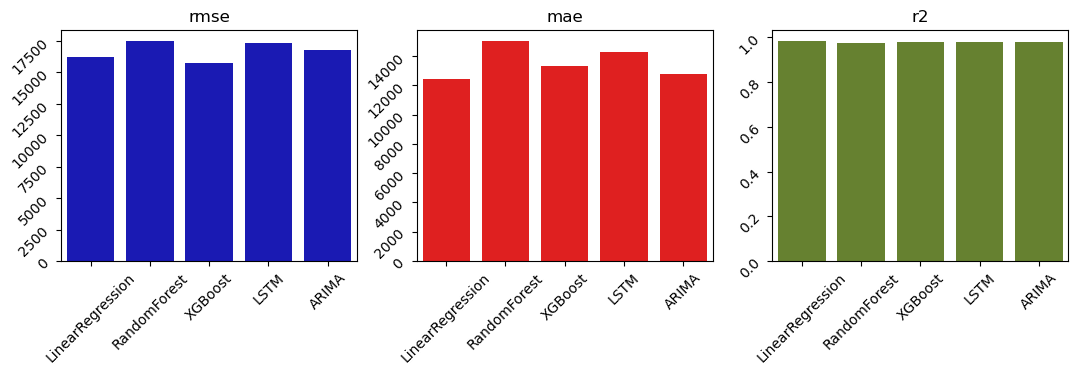

In [4]:
errors_plot = model.plot_errs()

In [5]:
output_df = pd.DataFrame(model.stored_models).T
output_df

,model,true_values,rmse,mae,r2,predictions
LinearRegression,LinearRegression(),"[-46105.0, 4063.000000000003, 201298.000000000...",16221.272385,12433.184266,0.981973,"[-15496.214934308946, 11031.378157652734, 1981..."
RandomForest,"(DecisionTreeRegressor(max_depth=20, max_featu...","[-46105.0, 4063.000000000003, 201298.000000000...",17465.06417,15004.331667,0.972999,"[-14553.76999999999, 6056.470000000021, 174540..."
XGBoost,"XGBRegressor(base_score=None, booster=None, ca...","[-46105.0, 4063.000000000003, 201298.000000000...",15701.124706,13342.738751,0.979936,"[-12755.06208926813, 12683.55750377475, 177869..."
LSTM,<keras.src.callbacks.History object at 0x160fb...,"[-46105.0, 4063.000000000003, 201298.000000000...",17319.242737,14270.977718,0.97733,"[-18896.332756563104, 3024.950600013124, 19193..."
ARIMA,"ARIMA(0,0,1)(0,1,0)[12]","[-46105.0, 4063.000000000003, 201298.000000000...",16777.731652,12739.848418,0.977639,"[-1542.8189860174011, 12518.0, 175923.99999999..."


# Visualize EDA

(<Figure size 800x300 with 1 Axes>,
 <Axes: title={'center': 'distrobution of sales per day'}, xlabel='sales per day', ylabel='count'>)

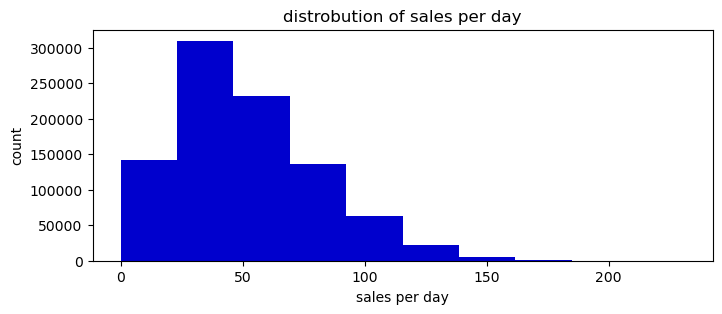

In [9]:
plot_periodic_values_hist(daily_data, value_col)

(<Figure size 800x300 with 1 Axes>,
 <Axes: title={'center': 'sales per group'}, xlabel='group id', ylabel='summed value for the group'>)

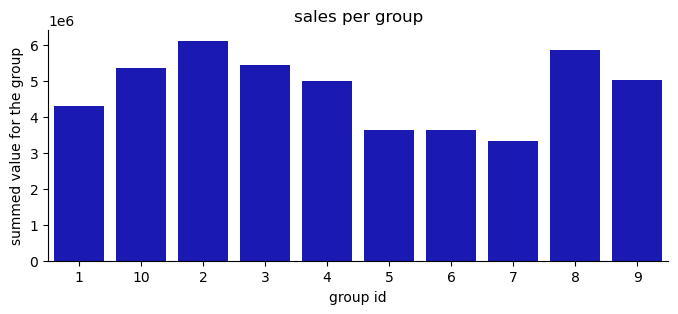

In [10]:
plot_values_per_group(daily_data, value_col, ['store'])

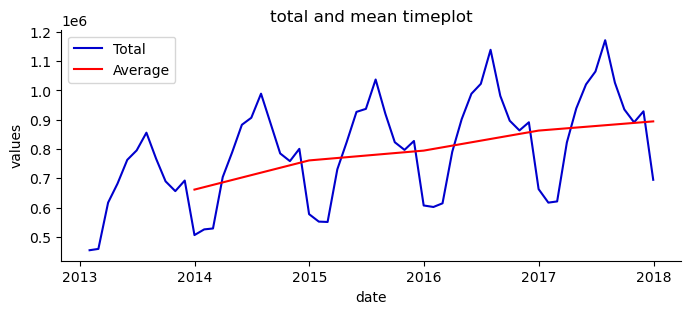

In [11]:
plot_time_series(monthly_data, date_col, value_col, mean_freq)

# Visualize Data Processing

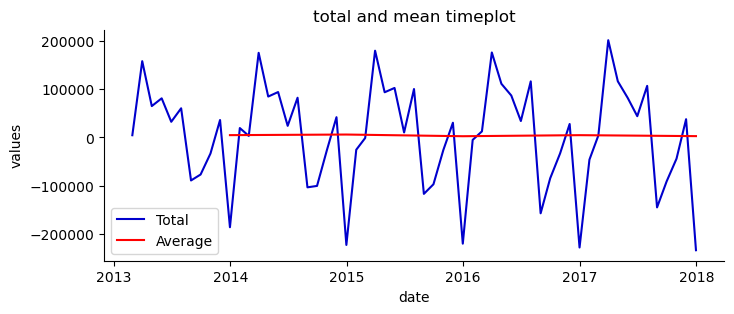

In [12]:
plot_time_series(monthly_data, date_col, diffed_value_col, mean_freq)

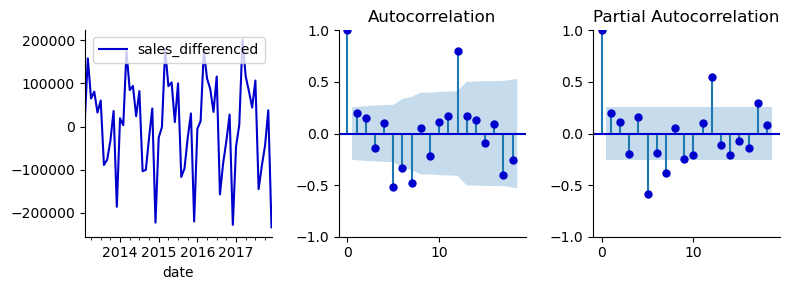

In [13]:
plt_acf_pcf(monthly_data, date_col, diffed_value_col)

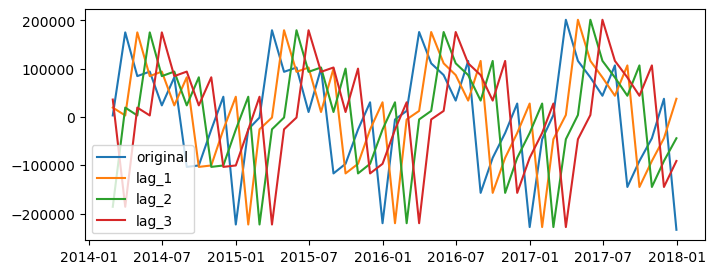

In [14]:

plot_lag_cols(supervised_data, date_col, diffed_value_col, 'lag', num_lags=3)

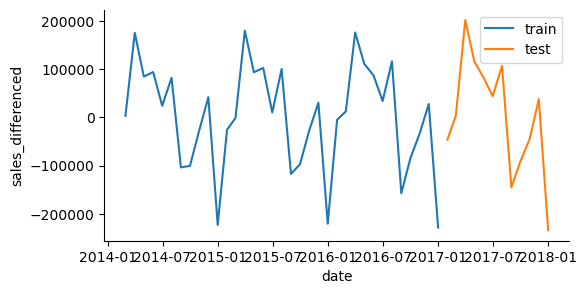

In [15]:
visualize_train_test(train, test, date_col, diffed_value_col, figsize=(12,4))